# Transfer Learning Image Classification
## Classifying NBA teams from images of NBA player profile pictures

The following notebook trains a multiclass image classification model using limited data with transfer learning.

Specifically, we will be training an image classifier to classify NBA player profile pictures to their corresponding NBA team using pretrained weights from [ResNet-50](https://www.mathworks.com/help/deeplearning/ref/resnet50.html;jsessionid=37c86264866975e6501afa94ba36).

## Global Configurations

In [1]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
import torch
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
from torch import nn

In [2]:
TEAMS_URL = 'https://www.nba.com/teams'
TEAMS_LINK_CLASS = 'TeamFigure_tfLinks__gwWFj'

In [3]:
DATA_DIR = 'nba_player_photos'

In [4]:
SEED = 0
if SEED is not None:
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  print(f'Random seed: {SEED}')

Random seed: 0


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data Preparation

### Scraping the data

Data will be NBA player profile pictures scraped from www.nba.com.
* There are **30** classes (NBA teams)
* There are **15-18** items per class (NBA players)
* Photos are **1040x760** pixels

**Note:** Depending on when the data is scraped, players may have since been traded and are on new teams from their original photos, thus introducing dirtiness to the data.

In [6]:
import requests
import shutil

from bs4 import BeautifulSoup
from pathlib import Path
from tqdm.notebook import tqdm

In [7]:
def get_team_infos():
  html = requests.get(TEAMS_URL).content
  soup = BeautifulSoup(html, 'html.parser')
  teams = []
  for team_links in soup.find_all('div', {'class': TEAMS_LINK_CLASS}):
    profile_link = next(team_links.children)
    link_parts = profile_link['href'].split('/')
    team_name, team_id = link_parts[3], link_parts[2]
    teams.append([team_name, team_id])
  return teams

In [8]:
team_infos = get_team_infos()
team_names = list(map(lambda team: team[0], team_infos))

Comment below to prevent clearing the `DATA_DIR` and forcing a fresh download

In [9]:
if Path(DATA_DIR).exists():
  shutil.rmtree(DATA_DIR)

Download photos to `DATA_DIR`

In [10]:
if Path(DATA_DIR).exists():
  print('Already downloaded all photos')
else:
  pbar = tqdm(team_infos)
  for team_name, team_id in pbar:
    pbar.set_description(f'Downloading {team_name} photos')
    Path(os.path.join(DATA_DIR, team_name)).mkdir(parents=True, exist_ok=True)
    team_url = f'https://www.nba.com/team/{team_id}/{team_name}'
    roster_table = None
    while roster_table == None: # loop in case of unsuccessful get request
      html = requests.get(team_url).content
      soup = BeautifulSoup(html, 'html.parser')
      roster_table = soup.find('table')
    roster_rows = roster_table.find_all('tr')
    for player_row in roster_rows[1:]: # skip header row
      link_parts = player_row.find('a')['href'].split('/')
      player_name, player_id = link_parts[3], link_parts[2]
      player_pic_url = \
        f'https://cdn.nba.com/headshots/nba/latest/1040x760/{player_id}.png'
      img_data = requests.get(player_pic_url).content
      if img_data.find(b'Error') == -1: # if image data is valid
        img_path = os.path.join(DATA_DIR, team_name, f'{player_name}.png')
        with open(img_path, 'wb') as f:
          f.write(img_data)
    if pbar.n + 1 == len(team_infos):
      pbar.set_description('Downloaded all photos')

  0%|          | 0/30 [00:00<?, ?it/s]

### Creating train/test data split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
TEST_SIZE = 0.15

In [13]:
TRAIN_PATH = os.path.join(DATA_DIR, 'train')
TEST_PATH = os.path.join(DATA_DIR, 'test')

In [14]:
if Path(TRAIN_PATH).exists() and Path(TEST_PATH).exists():
  print('Already split data into train/test')
else:
  train_paths = []
  test_paths = []
  for root, _, files in os.walk(DATA_DIR):
    if len(files) == 0:
      continue
    label = root.split('/')[1]
    train_files, test_files = train_test_split(
        files, test_size=TEST_SIZE, random_state=SEED)
    train_paths += list(map(lambda file: os.path.join(root, file), train_files))
    test_paths += list(map(lambda file: os.path.join(root, file), test_files))

Move photos into `train` and `test` directories and remove remaining directories

In [15]:
if Path(TRAIN_PATH).exists() and Path(TEST_PATH).exists():
  print('Already moved photos into train/test directories')
else:
  Path(TRAIN_PATH).mkdir(exist_ok=True)
  Path(TEST_PATH).mkdir(exist_ok=True)
  for file_path in train_paths:
    team_name = file_path.split('/')[1]
    team_train_path = os.path.join(TRAIN_PATH, team_name)
    if not os.path.exists(team_train_path):
      os.mkdir(team_train_path)
    filename = file_path.split('/')[-1]
    shutil.move(file_path, os.path.join(team_train_path, filename))
  for file_path in test_paths:
    team_name = file_path.split('/')[1]
    team_test_path = os.path.join(TEST_PATH, team_name)
    if not os.path.exists(team_test_path):
      os.mkdir(team_test_path)
    filename = file_path.split('/')[-1]
    shutil.move(file_path, os.path.join(team_test_path, filename))
  for team_name in team_names:
    shutil.rmtree(os.path.join(DATA_DIR, team_name))

#### Sample observation

In [16]:
sample_team_name = team_infos[0][0]
sample_team_path = os.path.join(TRAIN_PATH, sample_team_name)
sample_player_file = os.listdir(sample_team_path)[0]
sample_player_path = os.path.join(sample_team_path, f'{sample_player_file}')
sample_img = Image(sample_player_path)

observation: justin-jackson.png


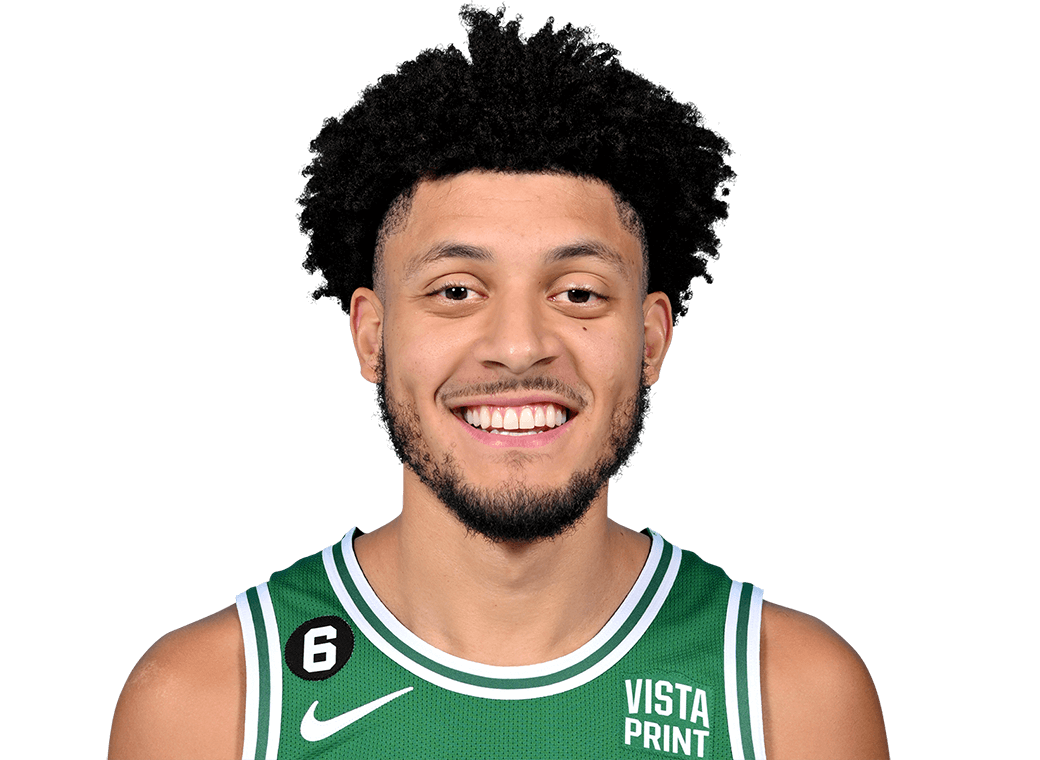

class: celtics


In [17]:
print(f'observation: {sample_player_file}')
display(sample_img)
print(f'class: {sample_team_name}')

### Create `DataLoaders` for dataset

In [18]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import ResNet50_Weights

In [19]:
BATCH_SIZE = 32
NUM_WORKERS = 1

In [20]:
transform_resnet50 = ResNet50_Weights.DEFAULT.transforms()

In [21]:
dataset_train = datasets.ImageFolder(
    root=TRAIN_PATH,
    transform=transform_resnet50)
dataset_test = datasets.ImageFolder(
    root=TEST_PATH,
    transform=transform_resnet50)

In [22]:
dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True)
dataloader_test = DataLoader(
    dataset=dataset_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False)

#### Sample input

Input images are transformed to be used in the ResNet-50 model

In [23]:
import PIL

In [24]:
sample_img_pil = PIL.Image.open(sample_player_path).convert('RGB')
sample_img_tensor = transforms.ToTensor()(sample_img_pil)
sample_img_transformed = transform_resnet50(sample_img_tensor)

input:


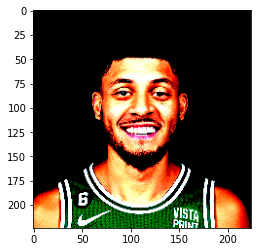

class: celtics


In [25]:
print('input:')
plt.imshow(sample_img_transformed.permute(1, 2, 0))
plt.show()
print(f'class: {sample_team_name}')

## Model Fitting

### Instantiate the Resnet-50 model for classification on data

In [26]:
from torchvision.models import resnet50

In [27]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

Freeze all of the weights in each layer except the last

In [28]:
for param in model.conv1.parameters():
  param.requires_grad = False
for param in model.bn1.parameters():
  param.requires_grad = False
for param in model.relu.parameters():
  param.requires_grad = False
for param in model.maxpool.parameters():
  param.requires_grad = False
for param in model.layer1.parameters():
  param.requires_grad = False
for param in model.layer2.parameters():
  param.requires_grad = False
for param in model.layer3.parameters():
  param.requires_grad = False
for param in model.layer4.parameters():
  param.requires_grad = False
for param in model.avgpool.parameters():
  param.requires_grad = False

Define new final classification (`fc`) layer with correct number of `out_features` and compute gradients

In [29]:
model.fc = nn.Linear(in_features=2048, out_features=len(team_names), bias=True)
for param in model.fc.parameters():
  param.requires_grad = True

### Define the `fit()` function

In [30]:
from sklearn.metrics import accuracy_score
from torch.optim import SGD

In [31]:
def fit(dataloader_train = dataloader_train,
        dataloader_test = dataloader_test,
        epochs = 100,
        loss_fn = nn.CrossEntropyLoss(),
        accuracy_fn = accuracy_score,
        optimizer = SGD(params=model.parameters(), lr=0.1),
        verbose = 1,
        early_stopping = 1,
        stop_after_k = 3):
  best = {
    'state_dict': None,
    'epoch': None,
    'loss_train': None,
    'accuracy_train': None,
    'loss_test': None,
    'accuracy_test': None
  }
  early_stop_k = 0
  losses_train = []
  losses_test = []
  accuracies_train = []
  accuracies_test = []
  for epoch in range(epochs):
    # Training
    model.train()
    loss_train = 0
    accuracy_train = 0
    for X_train, Y_train in tqdm(dataloader_train,
                                 desc=f'Training epoch {epoch}'):
      loss_batch, accuracy_batch = forward(
          X_train, Y_train, loss_fn, accuracy_fn)
      loss_train += loss_batch.item()
      accuracy_train += accuracy_batch
      optimizer.zero_grad()
      loss_batch.backward()
      optimizer.step()
    loss_train /= len(dataloader_train)
    losses_train.append(loss_train)
    accuracy_train /= len(dataloader_train)
    accuracies_train.append(accuracy_train)
    # Testing
    model.eval()
    loss_test = 0
    accuracy_test = 0
    with torch.inference_mode():
      for X_test, Y_test in dataloader_test:
        loss_batch, accuracy_batch = forward(
            X_test, Y_test, loss_fn, accuracy_fn)
        loss_test += loss_batch.item()
        accuracy_test += accuracy_batch
      loss_test /= len(dataloader_test)
      losses_test.append(loss_test)
      accuracy_test /= len(dataloader_test)
      accuracies_test.append(accuracy_test)
    # Verbose Print
    if verbose and epoch % verbose == 0:
      print_results(epoch, loss_train, accuracy_train, loss_test, accuracy_test)
    # Early Stopping
    if early_stopping and epoch % early_stopping == 0:
      if not best['loss_test'] or loss_test < best['loss_test']:
        early_stop_k = 0
        best['state_dict'] = model.state_dict()
        best['epoch'] = epoch
        best['loss_train'] = loss_train
        best['accuracy_train'] = accuracy_train
        best['loss_test'] = loss_test
        best['accuracy_test'] = accuracy_test
      else:
        early_stop_k += 1
        if early_stop_k >= stop_after_k:
          print(f'\nStopping Early\nBest', end=' ')
          print_results(best['epoch'], best['loss_train'],
                        best['accuracy_train'], best['loss_test'],
                        best['accuracy_test'])
          break
  model.load_state_dict(best['state_dict'])
  return losses_train, losses_test, accuracies_train, accuracies_test

def forward(X, Y, loss_fn, accuracy_fn):
  logits = model(X)
  pred = torch.softmax(logits, dim=1).argmax(dim=1)
  loss = loss_fn(logits.cpu(), Y.type(torch.LongTensor))
  accuracy = accuracy_fn(Y.cpu(), pred.cpu())
  return loss, accuracy

def print_results(epoch, loss_train, accuracy_train, loss_test, accuracy_test):
  print(f'Epoch: {epoch}', end=' | ')
  print(f'Train Loss: {loss_train:.4f}', end=', ')
  print(f'Train Acc: {accuracy_train:.1%}', end=' | ')
  print(f'Test Loss: {loss_test:.4f}', end=', ')
  print(f'Test Acc: {accuracy_test:.1%}')

### Fitting the model

In [32]:
%%time
losses_train, losses_test, accuracies_train, accuracies_test = fit()

Training epoch 0:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 3.3480, Train Acc: 7.0% | Test Loss: 3.2380, Test Acc: 22.0%


Training epoch 1:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 3.0181, Train Acc: 45.0% | Test Loss: 2.9855, Test Acc: 38.9%


Training epoch 2:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 2.6996, Train Acc: 72.8% | Test Loss: 2.7686, Test Acc: 73.3%


Training epoch 3:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 3 | Train Loss: 2.4196, Train Acc: 89.7% | Test Loss: 2.5860, Test Acc: 84.0%


Training epoch 4:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 4 | Train Loss: 2.1655, Train Acc: 93.5% | Test Loss: 2.4139, Test Acc: 84.0%


Training epoch 5:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 1.9133, Train Acc: 95.9% | Test Loss: 2.2593, Test Acc: 84.2%


Training epoch 6:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 1.7056, Train Acc: 95.0% | Test Loss: 2.1265, Test Acc: 90.5%


Training epoch 7:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 1.5303, Train Acc: 96.6% | Test Loss: 1.9954, Test Acc: 90.7%


Training epoch 8:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 1.3882, Train Acc: 98.2% | Test Loss: 1.8955, Test Acc: 92.0%


Training epoch 9:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 1.2432, Train Acc: 97.8% | Test Loss: 1.8080, Test Acc: 92.0%


Training epoch 10:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 1.1356, Train Acc: 98.3% | Test Loss: 1.7194, Test Acc: 92.0%


Training epoch 11:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 11 | Train Loss: 1.0229, Train Acc: 97.8% | Test Loss: 1.6414, Test Acc: 92.0%


Training epoch 12:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 12 | Train Loss: 0.9379, Train Acc: 98.1% | Test Loss: 1.5864, Test Acc: 92.0%


Training epoch 13:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 13 | Train Loss: 0.8370, Train Acc: 97.8% | Test Loss: 1.5107, Test Acc: 92.0%


Training epoch 14:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 0.7731, Train Acc: 98.1% | Test Loss: 1.4654, Test Acc: 92.0%


Training epoch 15:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 15 | Train Loss: 0.6992, Train Acc: 98.3% | Test Loss: 1.4131, Test Acc: 92.0%


Training epoch 16:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 0.6509, Train Acc: 98.3% | Test Loss: 1.3627, Test Acc: 92.0%


Training epoch 17:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 17 | Train Loss: 0.6292, Train Acc: 98.2% | Test Loss: 1.3350, Test Acc: 92.0%


Training epoch 18:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 18 | Train Loss: 0.5685, Train Acc: 99.0% | Test Loss: 1.2965, Test Acc: 92.0%


Training epoch 19:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 19 | Train Loss: 0.5336, Train Acc: 98.6% | Test Loss: 1.2639, Test Acc: 93.0%


Training epoch 20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 20 | Train Loss: 0.5011, Train Acc: 98.6% | Test Loss: 1.2326, Test Acc: 92.0%


Training epoch 21:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 21 | Train Loss: 0.4839, Train Acc: 99.3% | Test Loss: 1.1925, Test Acc: 92.0%


Training epoch 22:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 22 | Train Loss: 0.4414, Train Acc: 99.0% | Test Loss: 1.1723, Test Acc: 92.0%


Training epoch 23:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 23 | Train Loss: 0.4276, Train Acc: 99.0% | Test Loss: 1.1469, Test Acc: 92.0%


Training epoch 24:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 24 | Train Loss: 0.4116, Train Acc: 99.3% | Test Loss: 1.1332, Test Acc: 93.0%


Training epoch 25:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 25 | Train Loss: 0.3947, Train Acc: 99.0% | Test Loss: 1.1117, Test Acc: 92.0%


Training epoch 26:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 26 | Train Loss: 0.3642, Train Acc: 99.0% | Test Loss: 1.1029, Test Acc: 93.0%


Training epoch 27:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 27 | Train Loss: 0.3448, Train Acc: 99.0% | Test Loss: 1.0657, Test Acc: 93.0%


Training epoch 28:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 28 | Train Loss: 0.3437, Train Acc: 99.0% | Test Loss: 1.0535, Test Acc: 93.0%


Training epoch 29:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 29 | Train Loss: 0.3301, Train Acc: 99.0% | Test Loss: 1.0319, Test Acc: 92.0%


Training epoch 30:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 30 | Train Loss: 0.3032, Train Acc: 99.5% | Test Loss: 1.0194, Test Acc: 93.0%


Training epoch 31:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 31 | Train Loss: 0.2831, Train Acc: 99.2% | Test Loss: 1.0065, Test Acc: 92.0%


Training epoch 32:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 32 | Train Loss: 0.2886, Train Acc: 99.5% | Test Loss: 0.9844, Test Acc: 94.3%


Training epoch 33:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 33 | Train Loss: 0.2640, Train Acc: 99.4% | Test Loss: 0.9740, Test Acc: 93.0%


Training epoch 34:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 34 | Train Loss: 0.2522, Train Acc: 99.5% | Test Loss: 0.9706, Test Acc: 93.0%


Training epoch 35:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 35 | Train Loss: 0.2445, Train Acc: 99.5% | Test Loss: 0.9588, Test Acc: 93.0%


Training epoch 36:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 36 | Train Loss: 0.2274, Train Acc: 99.2% | Test Loss: 0.9486, Test Acc: 93.0%


Training epoch 37:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 37 | Train Loss: 0.2294, Train Acc: 99.5% | Test Loss: 0.9453, Test Acc: 93.0%


Training epoch 38:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 38 | Train Loss: 0.2191, Train Acc: 99.5% | Test Loss: 0.9306, Test Acc: 93.0%


Training epoch 39:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 39 | Train Loss: 0.2113, Train Acc: 99.3% | Test Loss: 0.9279, Test Acc: 93.0%


Training epoch 40:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 40 | Train Loss: 0.2122, Train Acc: 99.5% | Test Loss: 0.9060, Test Acc: 93.0%


Training epoch 41:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 41 | Train Loss: 0.1963, Train Acc: 99.5% | Test Loss: 0.8995, Test Acc: 93.0%


Training epoch 42:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 42 | Train Loss: 0.2044, Train Acc: 99.5% | Test Loss: 0.8978, Test Acc: 93.0%


Training epoch 43:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 43 | Train Loss: 0.1865, Train Acc: 99.2% | Test Loss: 0.8856, Test Acc: 93.0%


Training epoch 44:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 44 | Train Loss: 0.1827, Train Acc: 99.4% | Test Loss: 0.8824, Test Acc: 93.0%


Training epoch 45:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 45 | Train Loss: 0.1749, Train Acc: 99.5% | Test Loss: 0.8837, Test Acc: 93.0%


Training epoch 46:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 46 | Train Loss: 0.1795, Train Acc: 99.5% | Test Loss: 0.8734, Test Acc: 92.0%


Training epoch 47:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 47 | Train Loss: 0.1679, Train Acc: 100.0% | Test Loss: 0.8639, Test Acc: 93.0%


Training epoch 48:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 48 | Train Loss: 0.1588, Train Acc: 99.8% | Test Loss: 0.8510, Test Acc: 94.1%


Training epoch 49:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 49 | Train Loss: 0.1598, Train Acc: 99.5% | Test Loss: 0.8500, Test Acc: 94.1%


Training epoch 50:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 50 | Train Loss: 0.1538, Train Acc: 99.5% | Test Loss: 0.8405, Test Acc: 93.0%


Training epoch 51:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 51 | Train Loss: 0.1438, Train Acc: 99.8% | Test Loss: 0.8376, Test Acc: 94.3%


Training epoch 52:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 52 | Train Loss: 0.1444, Train Acc: 99.8% | Test Loss: 0.8252, Test Acc: 94.1%


Training epoch 53:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 53 | Train Loss: 0.1373, Train Acc: 100.0% | Test Loss: 0.8236, Test Acc: 94.1%


Training epoch 54:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 54 | Train Loss: 0.1408, Train Acc: 100.0% | Test Loss: 0.8294, Test Acc: 93.0%


Training epoch 55:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 55 | Train Loss: 0.1356, Train Acc: 100.0% | Test Loss: 0.8176, Test Acc: 93.0%


Training epoch 56:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 56 | Train Loss: 0.1274, Train Acc: 100.0% | Test Loss: 0.8110, Test Acc: 94.1%


Training epoch 57:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 57 | Train Loss: 0.1278, Train Acc: 99.8% | Test Loss: 0.8068, Test Acc: 94.1%


Training epoch 58:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 58 | Train Loss: 0.1201, Train Acc: 99.8% | Test Loss: 0.7947, Test Acc: 94.1%


Training epoch 59:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 59 | Train Loss: 0.1238, Train Acc: 99.7% | Test Loss: 0.7937, Test Acc: 94.1%


Training epoch 60:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 60 | Train Loss: 0.1133, Train Acc: 100.0% | Test Loss: 0.7938, Test Acc: 94.1%


Training epoch 61:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 61 | Train Loss: 0.1166, Train Acc: 100.0% | Test Loss: 0.7954, Test Acc: 94.1%


Training epoch 62:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 62 | Train Loss: 0.1148, Train Acc: 100.0% | Test Loss: 0.7855, Test Acc: 94.1%


Training epoch 63:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 63 | Train Loss: 0.1196, Train Acc: 100.0% | Test Loss: 0.7918, Test Acc: 94.1%


Training epoch 64:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 64 | Train Loss: 0.1056, Train Acc: 100.0% | Test Loss: 0.7784, Test Acc: 94.1%


Training epoch 65:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 65 | Train Loss: 0.1051, Train Acc: 100.0% | Test Loss: 0.7639, Test Acc: 94.1%


Training epoch 66:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 66 | Train Loss: 0.1118, Train Acc: 100.0% | Test Loss: 0.7707, Test Acc: 94.1%


Training epoch 67:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 67 | Train Loss: 0.1034, Train Acc: 100.0% | Test Loss: 0.7669, Test Acc: 95.4%


Training epoch 68:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 68 | Train Loss: 0.1033, Train Acc: 100.0% | Test Loss: 0.7626, Test Acc: 93.0%


Training epoch 69:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 69 | Train Loss: 0.1033, Train Acc: 100.0% | Test Loss: 0.7578, Test Acc: 94.1%


Training epoch 70:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 70 | Train Loss: 0.0965, Train Acc: 100.0% | Test Loss: 0.7613, Test Acc: 93.0%


Training epoch 71:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 71 | Train Loss: 0.1001, Train Acc: 99.8% | Test Loss: 0.7474, Test Acc: 94.1%


Training epoch 72:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 72 | Train Loss: 0.0951, Train Acc: 100.0% | Test Loss: 0.7491, Test Acc: 94.1%


Training epoch 73:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 73 | Train Loss: 0.0975, Train Acc: 100.0% | Test Loss: 0.7508, Test Acc: 93.0%


Training epoch 74:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 74 | Train Loss: 0.0846, Train Acc: 100.0% | Test Loss: 0.7464, Test Acc: 94.1%


Training epoch 75:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 75 | Train Loss: 0.0906, Train Acc: 100.0% | Test Loss: 0.7433, Test Acc: 93.0%


Training epoch 76:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 76 | Train Loss: 0.0858, Train Acc: 100.0% | Test Loss: 0.7420, Test Acc: 93.0%


Training epoch 77:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 77 | Train Loss: 0.0909, Train Acc: 100.0% | Test Loss: 0.7441, Test Acc: 94.1%


Training epoch 78:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 78 | Train Loss: 0.0847, Train Acc: 100.0% | Test Loss: 0.7371, Test Acc: 94.1%


Training epoch 79:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 79 | Train Loss: 0.0846, Train Acc: 100.0% | Test Loss: 0.7293, Test Acc: 94.1%


Training epoch 80:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 80 | Train Loss: 0.0810, Train Acc: 100.0% | Test Loss: 0.7297, Test Acc: 94.1%


Training epoch 81:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 81 | Train Loss: 0.0810, Train Acc: 100.0% | Test Loss: 0.7244, Test Acc: 94.1%


Training epoch 82:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 82 | Train Loss: 0.0807, Train Acc: 100.0% | Test Loss: 0.7179, Test Acc: 94.1%


Training epoch 83:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 83 | Train Loss: 0.0805, Train Acc: 100.0% | Test Loss: 0.7207, Test Acc: 93.0%


Training epoch 84:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 84 | Train Loss: 0.0784, Train Acc: 100.0% | Test Loss: 0.7155, Test Acc: 94.1%


Training epoch 85:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 85 | Train Loss: 0.0784, Train Acc: 100.0% | Test Loss: 0.7132, Test Acc: 94.1%


Training epoch 86:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 86 | Train Loss: 0.0796, Train Acc: 100.0% | Test Loss: 0.7136, Test Acc: 94.1%


Training epoch 87:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 87 | Train Loss: 0.0726, Train Acc: 100.0% | Test Loss: 0.7052, Test Acc: 94.1%


Training epoch 88:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 88 | Train Loss: 0.0811, Train Acc: 100.0% | Test Loss: 0.7182, Test Acc: 94.1%


Training epoch 89:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 89 | Train Loss: 0.0752, Train Acc: 100.0% | Test Loss: 0.7081, Test Acc: 95.4%


Training epoch 90:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 90 | Train Loss: 0.0752, Train Acc: 100.0% | Test Loss: 0.7074, Test Acc: 94.3%

Stopping Early
Best Epoch: 87 | Train Loss: 0.0726, Train Acc: 100.0% | Test Loss: 0.7052, Test Acc: 94.1%
CPU times: user 2h 50min 1s, sys: 6min 36s, total: 2h 56min 37s
Wall time: 2h 58min 58s


## Visualizing the Results

### Plotting `loss` and `accuracy`

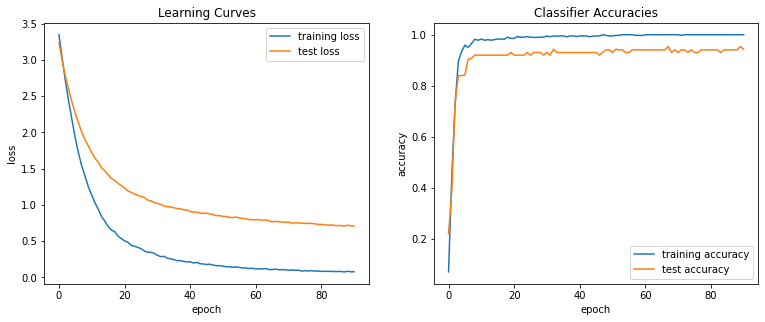

In [33]:
x = list(range(len(losses_train)))
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
# Subplot (1, 1)
sns.lineplot(ax=ax[0], x=x, y=losses_train)
sns.lineplot(ax=ax[0], x=x, y=losses_test)
ax[0].legend(['training loss', 'test loss'])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_title('Learning Curves')
# Subplot (1, 2)
sns.lineplot(ax=ax[1], x=x, y=accuracies_train)
sns.lineplot(ax=ax[1], x=x, y=accuracies_test)
ax[1].legend(['training accuracy', 'test accuracy'])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Classifier Accuracies')
plt.show()

### Confusion matrix

In [34]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

Make predictions with the model

In [35]:
Y_pred = []
Y_test = []
model.eval()
with torch.inference_mode():
  for X_batch, Y_batch in tqdm(dataloader_test,
                               desc='Making predictions in batches'):
    logits_test = model(X_batch)
    pred = torch.softmax(logits_test, dim=1).argmax(dim=1).cpu().numpy()
    Y_pred.append(pred)
    Y_test.append(Y_batch)
Y_pred = np.concatenate(Y_pred)
Y_test = np.concatenate(Y_test)

Making predictions in batches:   0%|          | 0/3 [00:00<?, ?it/s]

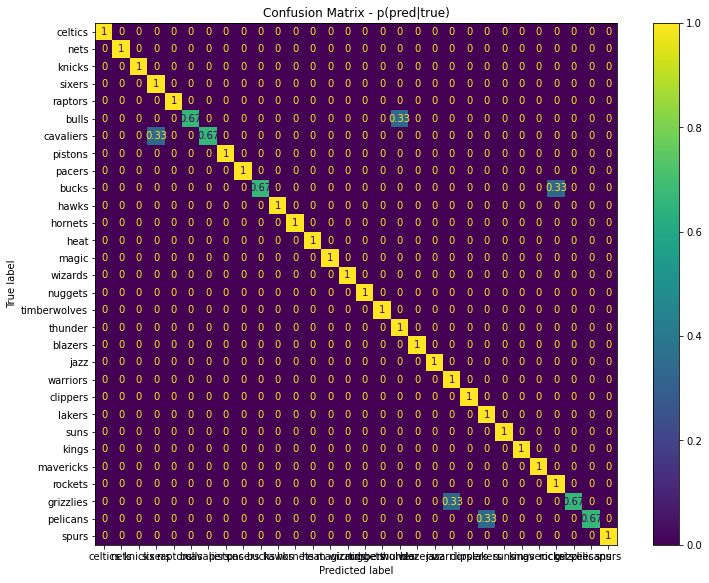

In [36]:
fig = plt.figure(figsize=(12.8, 9.6))
C = confusion_matrix(Y_test, Y_pred, normalize='true')
ConfusionMatrixDisplay(C, display_labels=team_names).plot(ax=fig.gca())
plt.title('Confusion Matrix - p(pred|true)')
plt.show()

## Conclusion

We can see that despite a small number of training and test observations, we are still able to learn the classes (team names) with high accuracy (over `94%`) in under 100 training epochs by applying knowledge gained from the pretrained ResNet-50 model via *transfer learning*.